In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image, ImageDraw
import os
import pandas as pd
import tqdm

from torchvision.transforms import v2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CustomFaceNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomFaceNet, self).__init__()
        self.facenet = InceptionResnetV1(pretrained='vggface2', classify=False).eval()

        for param in self.facenet.parameters():
            param.requires_grad = False

        self.logits = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.facenet(x)
        x = self.logits(x)
        return x


In [3]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.RandomResizedCrop(160, scale=(0.8, 1.0)),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    v2.RandomGrayscale(p=0.1),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.Resize(160),
    v2.ToTensor(),
])

c:\Users\thanh\AppData\Local\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
from torchvision import datasets

dataset = datasets.ImageFolder('Face Dataset/Train', transform=transforms)
dataloader = DataLoader(dataset, shuffle=True)
num_classes = len(dataset.classes)


In [5]:
model = CustomFaceNet(num_classes)

print(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    running_loss = 0.0
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch}, Loss: {running_loss/len(dataloader)}')
torch.save(model.state_dict(), 'models/facenet.pth')

cpu
Epoch: 0, Loss: 2.1046134531497955
Epoch: 1, Loss: 2.055146872997284
Epoch: 2, Loss: 2.022596761584282
Epoch: 3, Loss: 1.995435208082199
Epoch: 4, Loss: 1.9662160873413086
Epoch: 5, Loss: 1.932995468378067
Epoch: 6, Loss: 1.9073055535554886
Epoch: 7, Loss: 1.8880493193864822
Epoch: 8, Loss: 1.852277159690857
Epoch: 9, Loss: 1.8282759338617325
Epoch: 10, Loss: 1.7895135432481766
Epoch: 11, Loss: 1.7880786210298538
Epoch: 12, Loss: 1.7509153634309769
Epoch: 13, Loss: 1.7197094857692719
Epoch: 14, Loss: 1.6914309412240982
Epoch: 15, Loss: 1.6747811883687973
Epoch: 16, Loss: 1.6522886753082275
Epoch: 17, Loss: 1.624023199081421
Epoch: 18, Loss: 1.5947152823209763
Epoch: 19, Loss: 1.5722721964120865
Epoch: 20, Loss: 1.5378143340349197
Epoch: 21, Loss: 1.5400908589363098
Epoch: 22, Loss: 1.5178442746400833
Epoch: 23, Loss: 1.4991628229618073
Epoch: 24, Loss: 1.4636926352977753
Epoch: 25, Loss: 1.4329242259263992
Epoch: 26, Loss: 1.3724967688322067
Epoch: 27, Loss: 1.4071479588747025
Epoc

In [6]:
from IPython import display

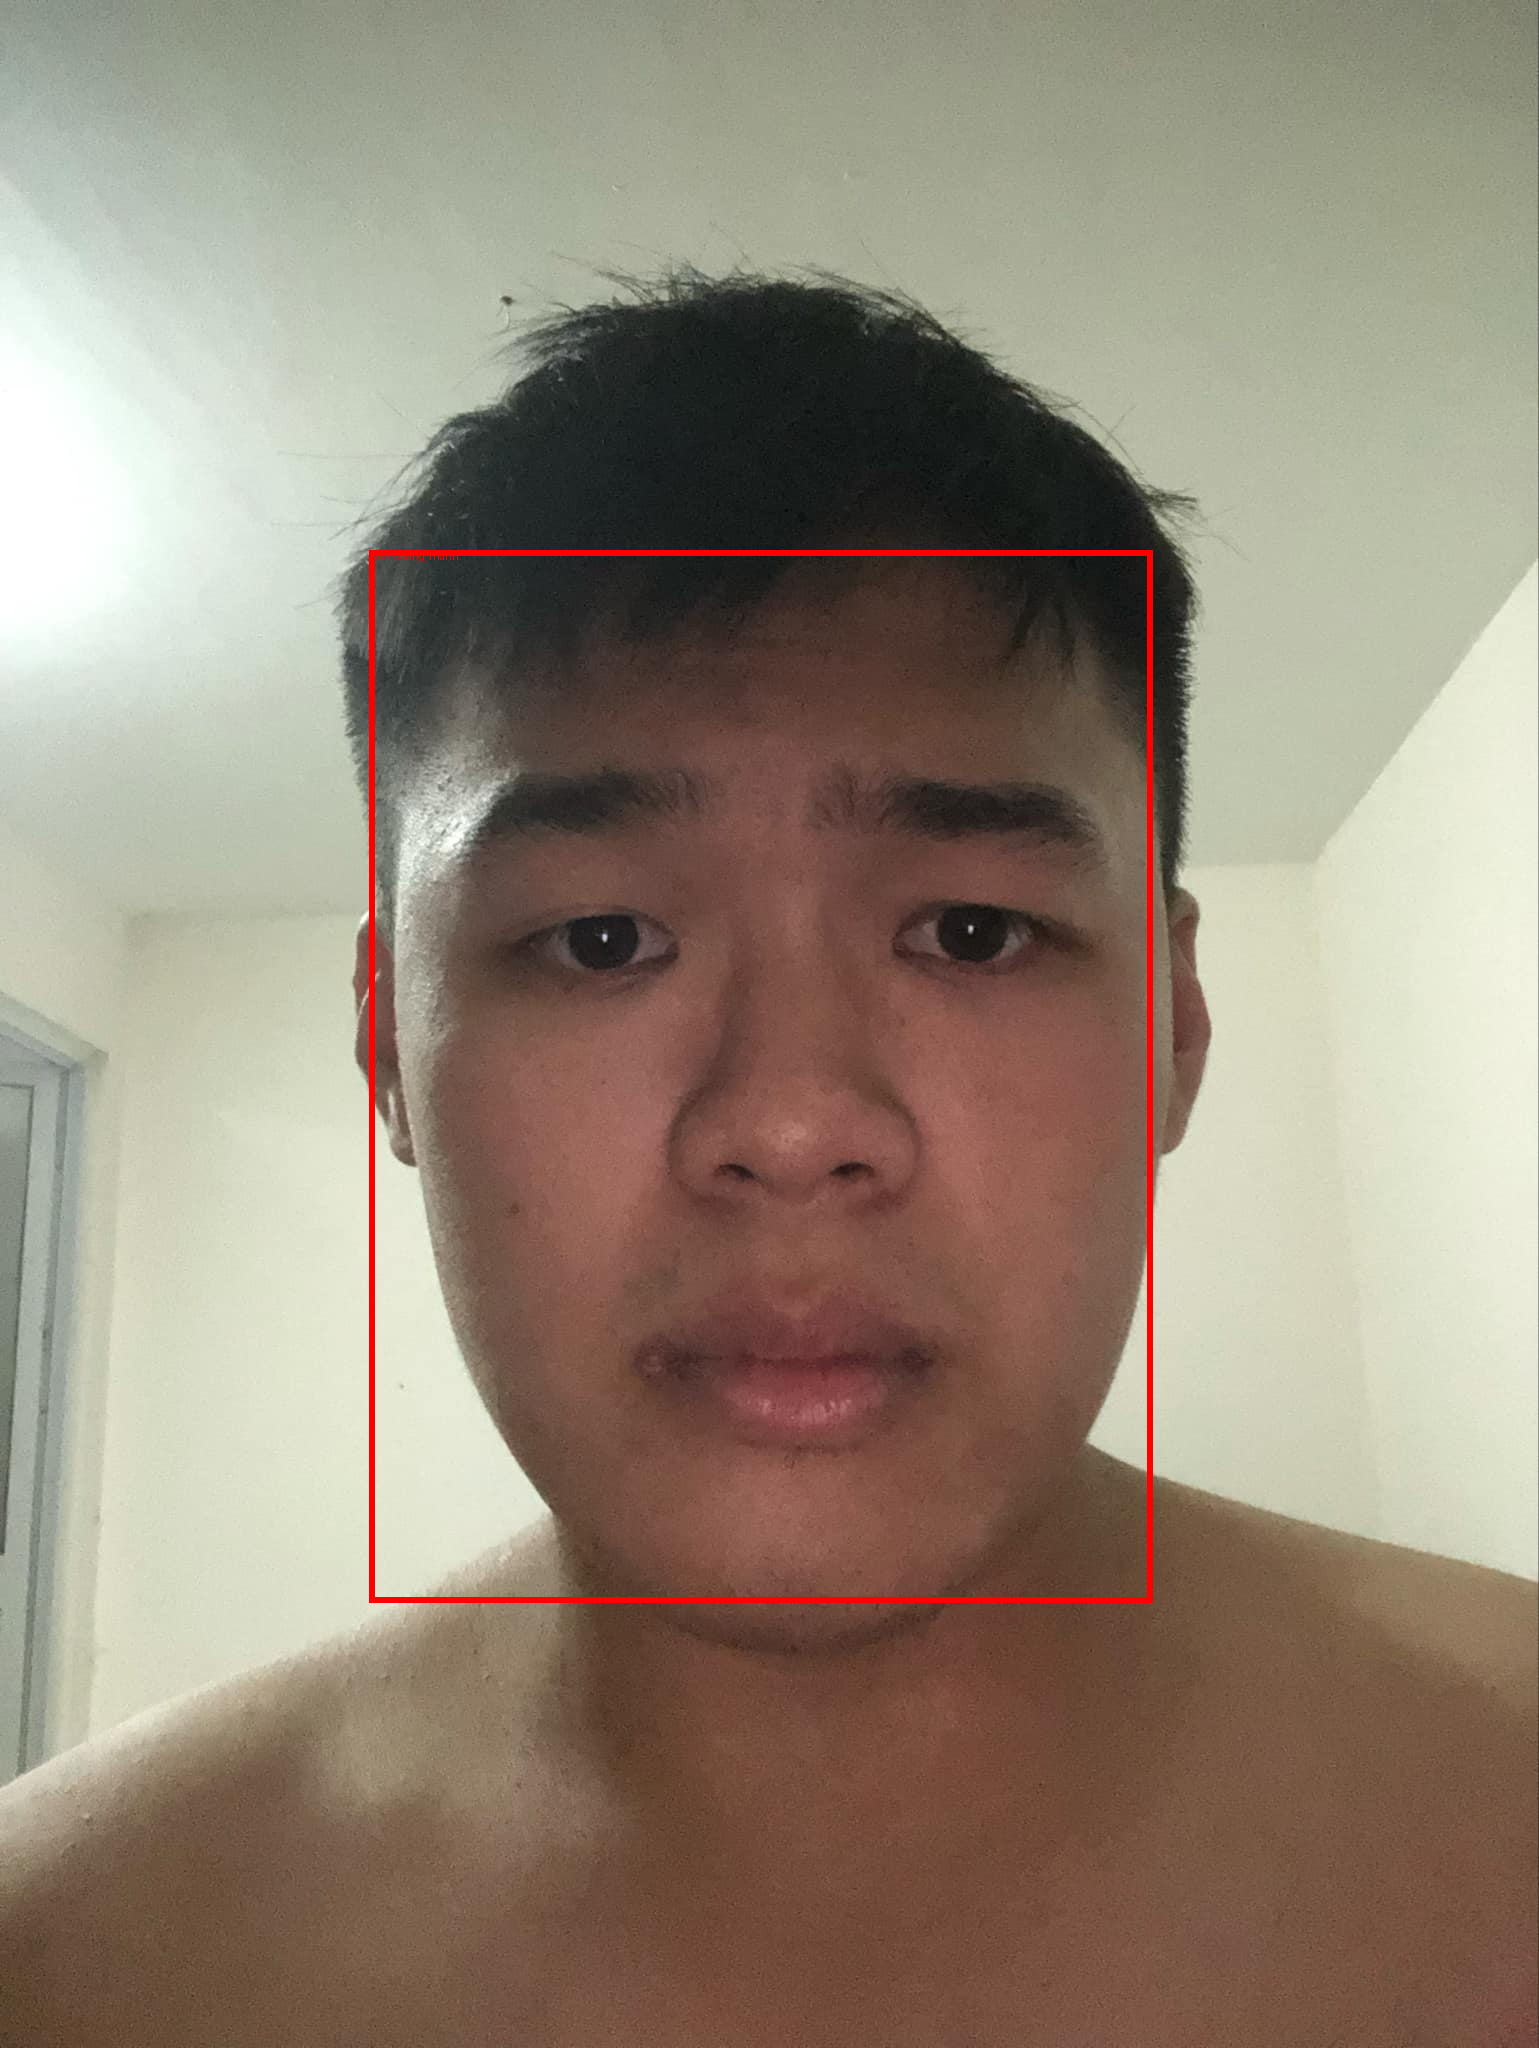

In [10]:
mtcnn = MTCNN(keep_all=True, device=device)
model = CustomFaceNet(num_classes)
model.load_state_dict(torch.load('models/facenet.pth'))
model.to(device)

def draw_boxes(image, boxes):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    return image

def get_faces(image):
    boxes, _ = mtcnn.detect(image)
    if boxes is not None:
        faces = [image.crop(box) for box in boxes]
        return faces, boxes
    return None, None

def get_embedding(face, transforms):
    face = transforms(face).unsqueeze(0).to(device)
    embedding = model(face)
    return embedding

def get_prediction(embedding):
    with torch.no_grad():
        prediction = torch.argmax(embedding, dim=1).item()
    return prediction

def get_name(prediction):
    return dataset.classes[prediction]

def recognize(image):
    faces, boxes = get_faces(image)
    if faces is not None:
        for face, box in zip(faces, boxes):
            embedding = get_embedding(face, transforms)
            prediction = get_prediction(embedding)
            name = get_name(prediction)
            image = draw_boxes(image, [box])
            draw = ImageDraw.Draw(image)
            draw.text((box[0], box[1]), name, font=None, fill=(255, 0, 0))
    return image

image = Image.open(r'E:\Project\Face Verification\Face Dataset\Test\Tran Quang Thanh\1603945b-5cf4-4082-8e53-6ed522bec447.jfif')
image = recognize(image)
display.display(image)
